## installations and imports

In [ ]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk
!sudo apt-get install xvfb xserver-xephyr vnc4server python-opengl ffmpeg

In [ ]:
%%capture
!pip install --upgrade 'setuptools==57.5.0'
!pip install 'gym==0.19.0'

In [ ]:
!pip install --upgrade wheel==0.38.4

In [ ]:
#%%capture
!pip install --upgrade minerl
!pip install pyvirtualdisplay

!pip install scikit-learn
!pip install -U colabgymrender

In [ ]:
import random
import numpy as np

import gym
import minerl

from tqdm.notebook import tqdm

from pyvirtualdisplay import Display
from sklearn.cluster import KMeans
from collections import Counter
import pandas as pd
import logging
logging.disable(logging.ERROR) # reduce clutter, remove if something doesn't work to see the error logs.

##read data

In [ ]:
minerl.data.download(directory='data', environment='MineRLObtainIronPickaxe-v0');

In [ ]:
from gym import spaces

In [ ]:
data=minerl.data.make("MineRLObtainIronPickaxe-v0")

##Data Analysis

### helpful functions

In [ ]:
def print_in_dict(dic,is_countain_array=True):
  # prints the keys and shapes of the values of the inventory dictionary
  for key in dic.keys():
    if is_countain_array:
      if type(dic[key]) is dict:
        for in_key in dic[key].keys():
          print(f"{key}:", in_key, dic[key][in_key].shape)
        continue
      print(key,dic[key].shape)
    else:
      if type(dic[key]) is dict:
        for in_key in dic[key].keys():
          print(f"{key}:", f"{in_key}:", dic[key][in_key])
        continue
      if key=="pov":
        print(f"{key}:",dic[key].shape)
        continue
      print(f"{key}:",dic[key])

In [ ]:
def recursive_unzip(dictionary, item_idx):
    """ "Unzip" dictionary """
    ret = {}
    for key, item in dictionary.items():
        if isinstance(item, dict):
            ret[key] = recursive_unzip(item, item_idx)
        else:
            ret[key] = item[item_idx]
    return ret

def unzip_states_or_actions(state_or_action_dict):
    """Turns the "raveled" states/actions from sarsd_iter into list of dicts"""
    ret = []
    num_items=len(state_or_action_dict.get("pov",state_or_action_dict.get("sneak")))
    for i in range(num_items):
        ret.append(recursive_unzip(state_or_action_dict, i))
    return ret

In [ ]:
def actions_to_vec(actions):
  # change the actions dictionary to a vector
  vec=[]
  for key,value in actions.items():
    if key=="camera":
      vec.append(value[0])
      vec.append(value[1])
    elif isinstance(value,str):
      vec.append(0)
    else:
      vec.append(value)
  return(vec)


def states_to_vec(states):
  # change the states dictionary to a vector
  vec=[]
  vec.append(states['equipped_items.mainhand.damage'])
  vec.append(states['equipped_items.mainhand.maxDamage'])
  if isinstance(states['equipped_items.mainhand.type'],str):

    vec.append(0)
  else:
    vec.append(states['equipped_items.mainhand.type'])
  for item in states["inventory"]:
    vec.append(states["inventory"][item])
  return(vec,states["pov"])

In [ ]:
def grouping(states,actions,rewards):
  """
  get a single batch data and convert it into tuple list (state,action,reward,pov)

  state- dict of states with seq_len items
  action- dict of actions with seq_len items
  reward- array of size seq_len
  """
  unzip_actions=unzip_states_or_actions(actions)
  unzip_states=unzip_states_or_actions(states)
  tuple_list=[]
  for i in range(len(unzip_actions)):
      action_vec=actions_to_vec(unzip_actions[i])

      state_vec,_=states_to_vec(unzip_states[i])

      tuple_list.append((state_vec,action_vec))
  return(tuple_list)

###states

In [ ]:
print_in_dict(states)

equipped_items.mainhand.damage (2, 10)
equipped_items.mainhand.maxDamage (2, 10)
equipped_items.mainhand.type (2, 10)
inventory: coal (2, 10)
inventory: cobblestone (2, 10)
inventory: crafting_table (2, 10)
inventory: dirt (2, 10)
inventory: furnace (2, 10)
inventory: iron_axe (2, 10)
inventory: iron_ingot (2, 10)
inventory: iron_ore (2, 10)
inventory: iron_pickaxe (2, 10)
inventory: log (2, 10)
inventory: planks (2, 10)
inventory: stick (2, 10)
inventory: stone (2, 10)
inventory: stone_axe (2, 10)
inventory: stone_pickaxe (2, 10)
inventory: torch (2, 10)
inventory: wooden_axe (2, 10)
inventory: wooden_pickaxe (2, 10)
pov (2, 10, 64, 64, 3)


In [ ]:
unzip_states=unzip_states_or_actions(states)
print("unzip_states size:",len(unzip_states))
print()
print_in_dict(unzip_states[0])

unzip_states size: 2

equipped_items.mainhand.damage (10,)
equipped_items.mainhand.maxDamage (10,)
equipped_items.mainhand.type (10,)
inventory: coal (10,)
inventory: cobblestone (10,)
inventory: crafting_table (10,)
inventory: dirt (10,)
inventory: furnace (10,)
inventory: iron_axe (10,)
inventory: iron_ingot (10,)
inventory: iron_ore (10,)
inventory: iron_pickaxe (10,)
inventory: log (10,)
inventory: planks (10,)
inventory: stick (10,)
inventory: stone (10,)
inventory: stone_axe (10,)
inventory: stone_pickaxe (10,)
inventory: torch (10,)
inventory: wooden_axe (10,)
inventory: wooden_pickaxe (10,)
pov (10, 64, 64, 3)


In [ ]:
unzip_of_unzip_states=unzip_states_or_actions(unzip_states[0])
print("unzip_of_unzip_actions size:",len(unzip_of_unzip_states))
print()
print_in_dict(unzip_of_unzip_states[0],False)

unzip_of_unzip_actions size: 10

equipped_items.mainhand.damage: 0
equipped_items.mainhand.maxDamage: 0
equipped_items.mainhand.type: none
inventory: coal: 0
inventory: cobblestone: 0
inventory: crafting_table: 0
inventory: dirt: 0
inventory: furnace: 0
inventory: iron_axe: 0
inventory: iron_ingot: 0
inventory: iron_ore: 0
inventory: iron_pickaxe: 0
inventory: log: 0
inventory: planks: 0
inventory: stick: 0
inventory: stone: 0
inventory: stone_axe: 0
inventory: stone_pickaxe: 0
inventory: torch: 0
inventory: wooden_axe: 0
inventory: wooden_pickaxe: 0
pov: (64, 64, 3)


###actions

In [ ]:
print_in_dict(actions)

attack (2, 10)
back (2, 10)
camera (2, 10, 2)
craft (2, 10)
equip (2, 10)
forward (2, 10)
jump (2, 10)
left (2, 10)
nearbyCraft (2, 10)
nearbySmelt (2, 10)
place (2, 10)
right (2, 10)
sneak (2, 10)
sprint (2, 10)


In [ ]:
unzip_actions=unzip_states_or_actions(actions)
print("unzip_actions size:",len(unzip_actions))
print()
print_in_dict(unzip_actions[0])

unzip_actions size: 2

attack (10,)
back (10,)
camera (10, 2)
craft (10,)
equip (10,)
forward (10,)
jump (10,)
left (10,)
nearbyCraft (10,)
nearbySmelt (10,)
place (10,)
right (10,)
sneak (10,)
sprint (10,)


In [ ]:
unzip_of_unzip_actions=unzip_states_or_actions(unzip_actions[0])
print("unzip_of_unzip_actions size:",len(unzip_of_unzip_actions))
print()
print_in_dict(unzip_of_unzip_actions[0],False)

unzip_of_unzip_actions size: 10

attack: 0
back: 0
camera: [0. 0.]
craft: none
equip: none
forward: 1
jump: 0
left: 0
nearbyCraft: none
nearbySmelt: none
place: none
right: 0
sneak: 0
sprint: 0


###create (state,action,reward,pov) tuple-list

In [ ]:
i=0
while data.batch_iter(2,seq_len=10) is not None and i<=5:
    x = next(data.batch_iter(2,seq_len=10))
    states,actions,rewards,state_prime,dones=x
    unzip_states=unzip_states_or_actions(states)
    unzip_actions=unzip_states_or_actions(actions)
    print(grouping(unzip_states[0],unzip_actions[0],rewards[0])[0])
    i+=1

### Plot Actions

In [ ]:
df_seq=pd.DataFrame(df)
df_seq

In [ ]:
IDs=df_seq["ID"].unique()
player_actions=[]
for i in IDs:
  new_df={"prev":[],"curr":[],"change":[]}
  r0=df_seq[df_seq["ID"]==i].iloc[0]
  prev_seq=r0["Action_Time"]
  change=r0["Change"]
  for idx,r in df_seq[df_seq["ID"]==i].iloc[1:].iterrows():
    new_df["prev"].append(prev_seq)
    curr=r["Action_Time"]
    new_df["curr"].append(r["Action_Time"])
    new_df["change"].append(change)
    prev_seq=curr
    change=r["Change"]
  new_df["prev"].append(prev_seq)
  new_df["curr"].append(prev_seq+1)
  new_df["change"].append(change)
  player_actions.append((i,new_df))

In [ ]:
pd.DataFrame(player_actions[0][1])

In [ ]:
import networkx as nx

In [ ]:
def print_10_first_changes(name,new_df):
  pos_or=[np.array([0., 0.]),
          np.array([1., 0.  ]),
          np.array([0., 0.2 ]),
          np.array([1., 0.25]),
          np.array([0., 0.4]),
          np.array([1. , 0.5]),
          np.array([0. , 0.6]),
          np.array([1., 0.75]),
          np.array([0., 0.8]),
          np.array([1., 1.]),
          np.array([0. , 1.])]
  data=pd.DataFrame(new_df).iloc[:10]
  G=nx.from_pandas_edgelist(data,"prev","curr",edge_attr="change",create_using=nx.DiGraph())
  print(name)
  print(pd.DataFrame(new_df).iloc[:10])
  pos={}
  for idx,i in enumerate(data["prev"]):
    pos[i]=pos_or[idx]
  pos[data["curr"][9]]=pos_or[10]
  nx.draw(G,pos=pos,with_labels = True,font_size=8)  # add other parameters
  edge_labels = nx.get_edge_attributes(G, "change")
  nx.draw_networkx_edge_labels(G, pos, edge_labels)
  print()

v3_conscious_tangerine_rain_bird-41_80960-91940
   prev  curr                               change
0   372   453                           [(log, 1)]
1   453   524                           [(log, 1)]
2   524   593                           [(log, 1)]
3   593   670                           [(log, 1)]
4   670   740                           [(log, 1)]
5   740   971                           [(log, 1)]
6   971  1084                           [(log, 2)]
7  1084  1089             [(planks, 4), (log, -1)]
8  1089  1266            [(planks, 28), (log, -7)]
9  1266  1337  [(crafting_table, 1), (planks, -4)]



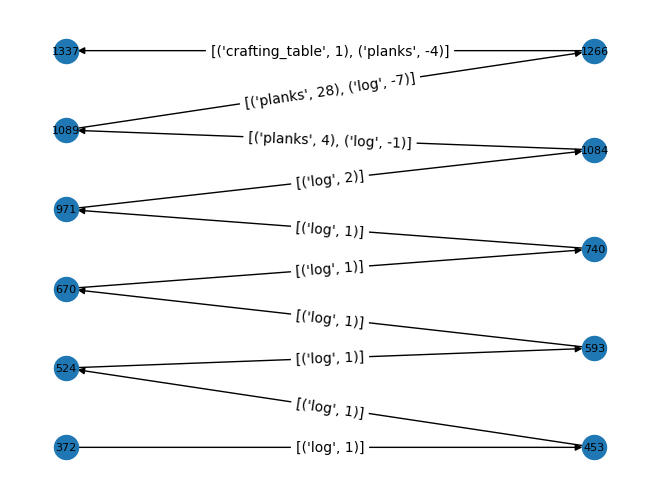

In [ ]:
print_10_first_changes(player_actions[0][0],player_actions[0][1])

v3_villainous_black_eyed_peas_loch_ness_monster-2_60815-67133
   prev  curr                                            change
0   259   316                                        [(log, 2)]
1   316   348                          [(planks, 4), (log, -1)]
2   348   404                          [(planks, 4), (log, -1)]
3   404   581               [(crafting_table, 1), (planks, -4)]
4   581   635                                        [(log, 1)]
5   635   665                          [(planks, 4), (log, -1)]
6   665   730                            [(crafting_table, -1)]
7   730   850                        [(stick, 4), (planks, -2)]
8   850   995  [(wooden_pickaxe, 1), (planks, -3), (stick, -2)]
9   995  1109      [(wooden_axe, 1), (planks, -3), (stick, -2)]



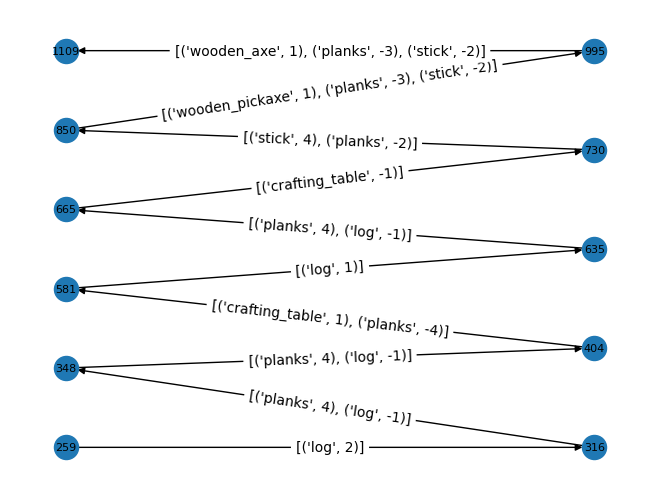

In [ ]:
print_10_first_changes(player_actions[1][0],player_actions[1][1])

## Create JSON files

In [ ]:
from collections import defaultdict
import csv
import json
import pickle

In [ ]:
trajectorys=data.get_trajectory_names()

###all changes for all players (table)

In [ ]:
df={"ID":[],"Change":[],"Seq_ID":[],"Action_Time":[]}

for t_names in trajectorys:
  first_player_lst=list(data.load_data(t_names))
  id=0
  for idx,(state,_,_,new_state,_) in enumerate(first_player_lst):
    change=[]
    prev=Counter(state["inventory"])
    curr=Counter(new_state["inventory"])
    #check add item
    for new_items in (curr-prev).items():
      change.append(new_items)
    for item,amount in (prev-curr).items():
      change.append((item,-amount))
    if len(change)!=0:
      id+=1
      df["ID"].append(t_names)
      df["Change"].append(change)
      df["Seq_ID"].append(id)
      df["Action_Time"].append(idx)


###action to transition

In [ ]:
data=minerl.data.make("MineRLObtainIronPickaxe-v0")

In [ ]:
# creating the changing_actions set and action_to_transition dictionary (set contains all actions that change the state and dictionary contains a mapping from action to the transitions that it caused)
changing_actions=set()
action_to_transition=defaultdict(list)

for t_names in trajectorys:
  first_player_lst=list(data.load_data(t_names))
  id=0
  for idx,(state,player_action,_,new_state,_) in enumerate(first_player_lst):
    change=[]
    prev_inv=Counter(state["inventory"])
    curr_inv=Counter(new_state["inventory"])
    prev_equ=state['equipped_items.mainhand.type']
    curr_equ=new_state['equipped_items.mainhand.type']
    if prev_equ!=curr_equ:

      change.append(("equipped",curr_equ))

    #check add item
    for key,val in (curr_inv-prev_inv).items():
      change.append((key,int(val)))
    for item,amount in (prev_inv-curr_inv).items():
      change.append((item,-int(amount)))
    if len(change)!=0:
      curr_acc_change=[]
      for acc,val in player_action.items():
        if acc!="camera" and val!=0 and val!='none':
          curr_acc_change.append((acc,val))
      state_small={'equipped_items.mainhand.type':state['equipped_items.mainhand.type'],"inventory":{key:int(val) for key,val in state["inventory"].items()}}
      new_state_small={'equipped_items.mainhand.type':new_state['equipped_items.mainhand.type'],"inventory":{key:int(val) for key,val in new_state["inventory"].items()}}
      action_to_transition[str(tuple(curr_acc_change))].append((state_small,new_state_small,change))
      changing_actions.add(str(tuple(curr_acc_change)))


In [ ]:
with open('action_to_transition.json', 'w') as f:
  json.dump(action_to_transition, f, indent = 3)

In [ ]:
with open('changing_actions.pkl','wb') as f:
   pickle.dump(changing_actions,f)

In [ ]:
# read the action_to_transition dictionary
# with open('action_to_transition.json', 'r') as j:
#   new_fun=json.load(j)

In [ ]:
# read the changing_actions set
# with open('changing_actions.pkl','rb') as f:
#    my_set = pickle.load(f)

###state to transition

In [ ]:
# creating the state_to_transition dictionary (dictionary contains a mapping from state to the actions that were taken from it)
state_to_transition=defaultdict(list)

for t_names in trajectorys:
  first_player_lst=list(data.load_data(t_names))
  id=0
  for idx,(state,player_action,_,new_state,_) in enumerate(first_player_lst):
    change=[]
    prev_inv=Counter(state["inventory"])
    curr_inv=Counter(new_state["inventory"])
    prev_equ=state['equipped_items.mainhand.type']
    curr_equ=new_state['equipped_items.mainhand.type']
    if prev_equ!=curr_equ:
      change.append(("equipped",curr_equ))

    #check add item
    for key,val in (curr_inv-prev_inv).items():
      change.append((key,int(val)))
    for item,amount in (prev_inv-curr_inv).items():
      change.append((item,-int(amount)))
    if len(change)!=0:
      curr_acc_change=[]
      for acc,val in player_action.items():
        if acc!="camera" and val!=0 and val!='none':
          try:
            curr_acc_change.append((acc,int(val)))
          except:
            curr_acc_change.append((acc,val))
      state_small={'equipped_items.mainhand.type':state['equipped_items.mainhand.type'],"inventory":{key:int(val) for key,val in state["inventory"].items()}}
      new_state_small={'equipped_items.mainhand.type':new_state['equipped_items.mainhand.type'],"inventory":{key:int(val) for key,val in new_state["inventory"].items()}}
      state_to_transition[json.dumps(state_small)].append(tuple(curr_acc_change))


In [ ]:
with open('state_to_transition.json', 'w') as f:
  json.dump(state_to_transition, f, indent = 3)

In [ ]:
## load the state_to_transition dictionary
# with open('state_to_transition.json', 'r') as f:
#    new_func = json.load(f)

###trajectory to plan steps

In [ ]:
# creating the trajectory_to_plan_steps dictionary (dictionary contains a mapping from trajectory index to the plan step id and transition that was taken from it)
trajectory_to_plan_steps=defaultdict(list)

for idx_t,t_names in enumerate(trajectorys):
  first_player_lst=list(data.load_data(t_names))
  id=0
  for idx,(state,player_action,_,new_state,_) in enumerate(first_player_lst):
    change=[]
    prev_inv=Counter(state["inventory"])
    curr_inv=Counter(new_state["inventory"])
    prev_equ=state['equipped_items.mainhand.type']
    curr_equ=new_state['equipped_items.mainhand.type']
    if prev_equ!=curr_equ:

      change.append(("equipped",curr_equ))

    #check add item
    for item,amount in (curr_inv-prev_inv).items():
      change.append((item,int(amount)))
    for item,amount in (prev_inv-curr_inv).items():
      change.append((item,-int(amount)))
    if len(change)!=0:
      curr_acc_change=[]
      for acc,val in player_action.items():
        if acc!="camera" and val!=0 and val!='none':
          try:
            curr_tuple=(acc,int(val))
          except:
            curr_tuple=(acc,val)
          curr_acc_change.append(curr_tuple)
      id+=1
      state_small={'equipped_items.mainhand.type':state['equipped_items.mainhand.type'],"inventory":{key:int(val) for key,val in state["inventory"].items()}}
      trajectory_to_plan_steps[idx_t].append((state_small,curr_acc_change,change,id))




In [ ]:
with open('trajectory_to_plan_steps.json', 'w') as f:
  json.dump(trajectory_to_plan_steps, f, indent = 3)

In [ ]:
## load the trajectory_to_plan_steps dictionary
# with open('trajectory_to_plan_steps.json', 'r') as f:
#    new_func = json.load(f)

### POV cluster to actions

In [ ]:
knn = pickle.load(open('30000pov_10eps_10min_50k/KNN_povs.pkl', "rb"))

def predict_pov_cluster(model, pov):
    """
    Predict cluster label of a single POV

    Args:
        model: instance of the clustering model
        pov: 64*64*3 array
    """
    # Normalize the new pov
    pov_normalized = pov / 255.0
    # Predict the label of the new pov
    label = model.predict(pov_normalized.reshape(1, -1))
    return label[0]

In [ ]:
# creating the state_to_transition_with_pov dictionary (dictionary contains a mapping from state to the actions that were taken from it and the pov cluster)
changing_actions=set()
state_to_transition_with_pov=defaultdict(list)

for t_names in trajectorys:
  first_player_lst=list(data.load_data(t_names))
  id=0

  for idx,(state,player_action,_,new_state,_) in enumerate(first_player_lst):
    change=[]
    prev_inv=Counter(state["inventory"])
    curr_inv=Counter(new_state["inventory"])
    prev_equ=state['equipped_items.mainhand.type']
    curr_equ=new_state['equipped_items.mainhand.type']

    if prev_equ!=curr_equ:
      change.append(("equipped",curr_equ))

    #check add item
    for key,val in (curr_inv-prev_inv).items():
      change.append((key,int(val)))
    for item,amount in (prev_inv-curr_inv).items():
      change.append((item,-int(amount)))
    if len(change)!=0:
      curr_acc_change=[]
      for acc,val in player_action.items():
        if acc!="camera" and val!=0 and val!='none':
          try:
            curr_acc_change.append((acc,int(val)))
          except:
            curr_acc_change.append((acc,val))

      pov_cluster = predict_pov_cluster(knn, np.array(state['pov']))
      state_small={'equipped_items.mainhand.type':state['equipped_items.mainhand.type'],
                   'inventory':{key:int(val) for key,val in state['inventory'].items()},
                   'pov_cluster': int(pov_cluster)}

      state_to_transition_with_pov[int(pov_cluster)].append(tuple(curr_acc_change))
      changing_actions.add(str(tuple(curr_acc_change)))

In [ ]:
with open('pov_cluster_to_transition_with_30K_pov.json', 'w') as f:
  json.dump(state_to_transition_with_pov, f, indent = 3)

In [ ]:
## load the state_to_transition_with_pov dictionary
# with open('state_to_transition_with_50K_pov.json','r') as f:
#    state_act = json.load(f)
#    state_act_dicts = [(json.loads(key), value) for key, value in state_act.items()]

### POV cluster to actions counter

In [ ]:
pov_to_actions_counter = defaultdict(Counter)

for i, t_names in enumerate(trajectorys):
    first_player_lst = list(data.load_data(t_names))
    # print(i)
    for idx,(state,player_action,_,new_state,_) in enumerate(first_player_lst):
        pov_cluster = predict_pov_cluster(knn, np.array(state['pov']))
        # equipped_item = state['equipped_items.mainhand.type']

        for acc, val in player_action.items():
            if acc != "camera" and val != 0 and val != 'none':
                if isinstance(val, str):
                    pov_to_actions_counter[int(pov_cluster)][str(acc)+str(val)] += 1
                else:
                    pov_to_actions_counter[int(pov_cluster)][str(acc)] += int(val)

In [ ]:
with open('pov_to_actions_counter.json', 'w') as f:
  json.dump(pov_to_actions_counter, f, indent = 3)